In [ ]:
! pip install -q langgraph langsmith langchain langchain_groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 896.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.7/407.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/

In [ ]:
! pip install -q arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.4 MB/s eta 0:00:00


In [ ]:
# Working with Tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

# Arxive Wikipedia Tools

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxive_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)
wiki_tool=WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [ ]:
wiki_tool.invoke("What is the capital of Italy?")

'Page: Rome\nSummary: Rome (Italian and Latin: Roma, pronounced [ˈroːma] ) is the capital city of Italy. It is also the capital of the Lazio region, the centre of the Metropolitan City of Rome Capital, and a special comune (municipality) named Comune di Roma Capitale. With 2,860,009 residents in 1,285'

In [ ]:
arxive_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [ ]:
tools = [wiki_tool]

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

In [ ]:
# LangGraph Application

from langgraph.graph.message import add_messages

class State(TypedDict):
  messages:Annotated[list, add_messages]

In [ ]:
from langgraph.graph import StateGraph, START, END

In [ ]:
graph_builder = StateGraph(State)

In [ ]:
from langchain_groq import ChatGroq

In [ ]:
#import userdata
from google.colab import userdata
groq_api_key = userdata.get('groq_api_key')

In [ ]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7edb4fe82950>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7edb4fe81660>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
llm_with_tools=llm.bind_tools(tools=tools)

In [ ]:
def chatbot(state:State):
  return {"messages": llm_with_tools.invoke(state['messages'])}

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
graph_builder.add_node('chatbot', chatbot)
graph_builder.add_edge(START, 'chatbot')
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)


graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END )

In [ ]:
graph=graph_builder.compile()

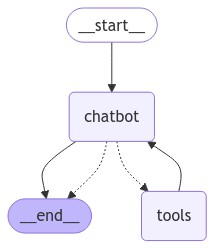

In [ ]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
user_input="Hi there!, My name is Imran Khan"

events = graph.stream(
    {'messages': [('user', user_input)]}, stream_mode="values"
)

for event in events:
  event['messages'][-1].pretty_print()


================================ Human Message =================================

Hi there!, My name is Imran Khan
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_02gg)
 Call ID: call_02gg
  Args:
    query: Imran Khan
================================= Tool Message =================================
Name: wikipedia

Page: Imran Khan
Summary: Imran Ahmed Khan Niazi (Urdu: عمران احمد خان نیازی , pronounced [ɪmɾaːn ɛɦməd xaːn nɪjaːziː]; born 5 October 1952) is a Pakistani politician and former cricketer who served as the 22nd prime minister of Pakistan from August 2018 until April 2022. He is the founder and forme
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_hh1c)
 Call ID: call_hh1c
  Args:
    query: Imran Khan Niazi
================================= Tool Message =================================
Name: wikipedia

Page: Imran Khan
Summary: Imran Ahmed Khan Niazi